In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
%matplotlib inline

In [43]:
def phi_pol(x, orden):
    pol = []
    for i in orden:
            pol.append(x**int(i))
    return np.array(pol).T


def modelo2(x, pre_mod, params):
    m = pre_mod + params[0]*np.sin(params[1]*x + params[2])*np.exp(params[3]*x)
    return m

def LL(y, mod, sigma_e):
    """
    log likelihodd para calcular
    """
    return - 0.5*(len(y)*np.log(2*np.pi*sigma_e**2) + np.sum((y - mod)**2)/sigma_e**2)

def log_like(params, x, y, pre_mod, sigma_e, modelo):
    """
    para optimizar
    """
    mod = modelo(x, pre_mod, params)
    arg = - 0.5*(len(y)*np.log(2*np.pi*sigma_e**2) + np.sum((y - mod)**2)/sigma_e**2)
    return - 1*arg # esta con el -1 para asi minimizar esa funcion


def MAP(x, y, orden, basis='pol', reg=0):
    """
    Retorna:
    t: estimador MAP
    """
    d = len(orden)
    if basis=='pol':
        p = phi_pol(x, orden=orden)
    # t = np.linalg.inv(p.T@p + reg*np.ones((d, d)))@p.T@y
    t = np.linalg.solve(p.T@p + reg*np.ones((d, d)), p.T@y)
    return t


def error(y_real, y_mod):
    return np.sum((y_real - y_mod)**2)/len(y_real)

$Y = \Phi(X) \theta + \eta$

$\theta_{\text{MAP}} = (\Phi^{T}(X)\Phi(X))^{-1} \Phi^{T}(X) Y$

$\theta_{\text{MAP REG}} = (\Phi^{T}(X)\Phi(X) + \rho \mathbb{1})^{-1} \Phi^{T}(X) Y$

$\Phi(X) \in N \text{x} D$

$\rho = \frac{\sigma_{\epsilon}^{2}}{\sigma_{\theta}^{2}}$

Donde $\sigma_{\theta}^{2}$ es la varianza del prior y $\sigma_{\epsilon}^{2}$ es la varianza del error de medición. 

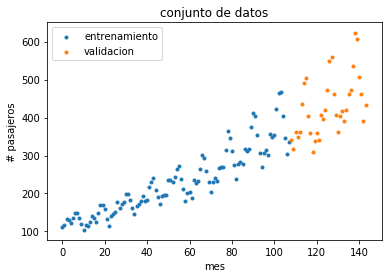

In [44]:
np.random.seed(4546)

data = np.loadtxt('datosT2.txt')
n_train = int(12*9)
mes_train = data[:n_train, 0]
pax_train = data[:n_train, 1]
mes_val = data[n_train:, 0]
pax_val = data[n_train:, 1]
plt.scatter(mes_train, pax_train, label='entrenamiento', marker='.')
plt.scatter(mes_val, pax_val, label='validacion', marker='.')
plt.legend()
plt.xlabel('mes')
plt.ylabel('# pasajeros')
plt.title('conjunto de datos')
plt.savefig('datos', dpi=123)

reg 1.9999999999999996


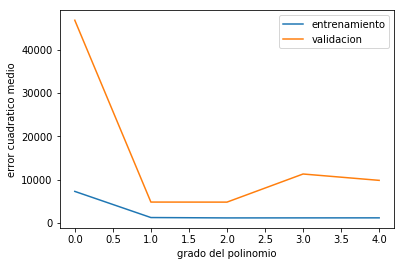

In [45]:
s_e = 2 # std datos
s_t = np.sqrt(2) # std params
rho = (s_e/s_t)**2 # constante de regularizacion
print('reg', rho)

n_max = 4
e_t = []
e_v = []
for i in range(n_max + 2)[1:]:
    theta_map = MAP(mes_train, pax_train, orden=np.arange(0, i, 1), basis='pol', reg=rho)
    p_train = phi_pol(mes_train, orden=np.arange(0, i, 1))
    p_val = phi_pol(mes_val, orden=np.arange(0, i, 1))
    mod1 = p_train@theta_map
    val1 = p_val@theta_map
    e_train = error(pax_train, mod1)
    e_val = error(pax_val, val1)
    e_t.append(e_train)
    e_v.append(e_val)
plt.plot(np.arange(0, n_max + 1, 1), e_t, label='entrenamiento')
plt.plot(np.arange(0, n_max + 1, 1), e_v, label='validacion')
#plt.ylim([0, 10000])
plt.xlabel('grado del polinomio')
plt.ylabel('error cuadratico medio')
plt.legend()
plt.savefig('error_pol', dpi=123)


El grado del polinomio mas probable es 2.

In [46]:
p_train = phi_pol(mes_train, orden=np.arange(0, 3, 1))
p_val = phi_pol(mes_val, orden=np.arange(0, 3, 1))
theta_map = MAP(mes_train, pax_train, orden=np.arange(0, 3, 1), basis='pol', reg=rho)
mod1 = p_train@theta_map
val1 = p_val@theta_map

theta_map = [1.03545195e+02 1.82829639e+00 7.19520170e-03]
                         mod1
error de entrenamiento = 1140
error de validacion    = 4792


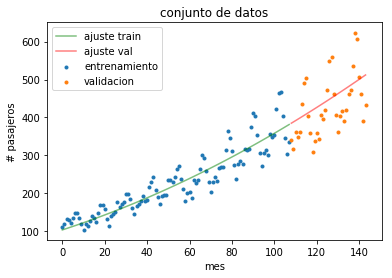

In [47]:
data = np.loadtxt('datosT2.txt')
n_train = int(12*9)
mes_train = data[:n_train, 0]
pax_train = data[:n_train, 1]
mes_val = data[n_train:, 0]
pax_val = data[n_train:, 1]
plt.scatter(mes_train, pax_train, label='entrenamiento', marker='.')
plt.scatter(mes_val, pax_val, label='validacion', marker='.')
plt.plot(mes_train, mod1, label='ajuste train', color='green', alpha=0.5)
plt.plot(mes_val, val1, label='ajuste val', color='red', alpha=0.5)
plt.legend()
plt.xlabel('mes')
plt.ylabel('# pasajeros')
plt.title('conjunto de datos')
plt.savefig('modelo_pol', dpi=123)

l_v_1 = LL(y=pax_val, mod=val1, sigma_e=s_e)
e_e_1 = int(error(pax_train, mod1))
e_v_1 = int(error(pax_val, val1))

print('theta_map =', theta_map)
print('                         mod1')
print('error de entrenamiento =', e_e_1)
print('error de validacion    =', e_v_1)

Se eligen ciertas adivinanzas para cada parametro:

$\theta_{1}$: aleatorio en [1, 10], $U(1, 10)$. 

$\theta_{2}$: analizando los maximos periodicos de los datos, el periodo es $T\approx10$ meses. Luego, una adivinanza educada puede ser un numero aleatorio $\mathcal{N}(\frac{2\pi}{T}, 1)$.

$\theta_{3}$: aleatorio $U(0, 2\pi)$.

$\theta_{4}$: se usa el hint 0.01.

/home/mauricio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in square
/home/mauricio/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:643: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/mauricio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in square
/home/mauricio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in square
/home/mauricio/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:643: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/mauricio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in square
/home/mauricio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow enco

x0 = [2.66975023 0.65264783 0.33554999 0.01      ]
xf = [12.00557431 -0.52037036  4.2978643   0.01735247]
                         mod1 mod2
error de entrenamiento = 1140 367
error de validacion    = 4792 1920


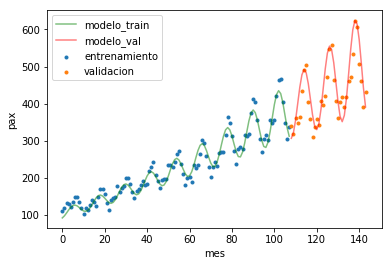

In [48]:
plt.scatter(mes_train, pax_train, label='entrenamiento', marker='.')
plt.scatter(mes_val, pax_val, label='validacion', marker='.')
plt.xlabel('mes')
plt.ylabel('pax')

# adivinanzas
T = 10
t1 = np.random.uniform(1, 10)
t2 = np.random.normal(2*np.pi/T, 1)
t3 = np.random.uniform(0, 2*np.pi)
x0 = np.array([t1, t2, t3, 0.01])
tol = 1e-1

con = False # condicion de convergencia de la minimizacion
con2 = False # condicion de que el tercer modelo sea mejor que el segundo
while not con2:
    while not con:
        t1 = np.random.uniform(1, 10)
        t2 = np.random.normal(2*np.pi/T, 1)
        t3 = np.random.uniform(0, 2*np.pi)
        x0 = np.array([t1, t2, t3, 0.01])    
        res2 = minimize(fun=log_like, x0=x0, args=(mes_train, pax_train, mod1, s_e, modelo2), 
                        method='BFGS', tol=tol)
        mod2 = modelo2(x=mes_train, pre_mod=mod1, params=res2.x)
        val2 = modelo2(x=mes_val, pre_mod=val1, params=res2.x)
        l_v_2 = LL(y=pax_val, mod=val2, sigma_e=s_e)
        con = res2.success
    e_e_2 = int(error(pax_train, mod2))
    e_v_2 = int(error(pax_val, val2))
    if e_e_2<e_e_1*0.75 and e_v_2<e_v_1: # se exige que el error de entrenamiento nuevo sea 
                                      # al menos 0.75 del anterior
        con2 = True
    else:
        con = False
""" 
params = np.array([-11.95620611, 5.76230835, 7.47860343, 0.01739311])
mod2 = modelo2(x=mes_train, pre_mod=mod1, params=params)
val2 = modelo2(x=mes_val, pre_mod=val1, params=params)
"""
plt.plot(mes_train, mod2, label='modelo_train', color='green', alpha=0.5)
plt.plot(mes_val, val2, label='modelo_val', color='red', alpha=0.5)
plt.legend()
plt.savefig('modelo_1', dpi=123)
    
print('x0 =', x0)
print('xf =', res2.x)
print('                         mod1 mod2')
print('error de entrenamiento =', e_e_1, e_e_2)
print('error de validacion    =', e_v_1, e_v_2)

Manteniendo las adivinanzas para los parámetros, excepto para $\theta_{2}$, la cual puede ser pensada como un armonico de $\theta_{2}$  inicialmente:

$\theta_{2} = \mathcal{N}(\frac{2\pi n}{T}, 1)$

Suponiendo que inicialmente $\theta_{2}$ es el segundo armónico de la frecuencia inicial anterior, $n \approx 2$.

x0 = [1.32856898 1.22613182 2.96148041 0.01      ]
xf = [9.59057095e+00 1.05339402e+00 1.92726010e+01 1.17653645e-02]
                         mod1 mod2 mod3
error de entrenamiento = 1140 367  161
error de validacion    = 4792 1920 1166


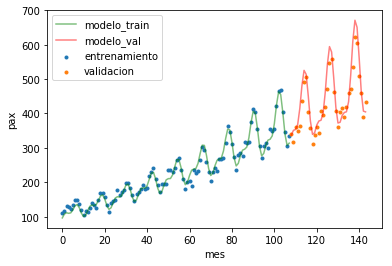

In [49]:
plt.scatter(mes_train, pax_train, label='entrenamiento', marker='.')
plt.scatter(mes_val, pax_val, label='validacion', marker='.')
plt.xlabel('mes')
plt.ylabel('pax')

# adivinanzas
T = 10
n = 2
t1 = np.random.uniform(1, 10)
t2 = np.random.normal(2*np.pi/T*n, 1)
t3 = np.random.uniform(0, 2*np.pi)
x0 = np.array([t1, t2, t3, 0.01])
tol = 1e-1

con = False # condicion de convergencia de la minimizacion
con2 = False # condicion de que el tercer modelo sea mejor que el segundo
while not con2:
    while not con:
        t1 = np.random.uniform(1, 10)
        t2 = np.random.normal(2*np.pi/T*n, 1)
        t3 = np.random.uniform(0, 2*np.pi)
        x0 = np.array([t1, t2, t3, 0.01])    
        res3 = minimize(fun=log_like, x0=x0, args=(mes_train, pax_train, mod2, s_e, modelo2), method='BFGS', tol=tol)
        mod3 = modelo2(x=mes_train, pre_mod=mod2, params=res3.x)
        val3 = modelo2(x=mes_val, pre_mod=val2, params=res3.x)
        l_v_3 = LL(y=pax_val, mod=val3, sigma_e=s_e)
        con = res3.success
    e_e_3 = int(error(pax_train, mod3))
    e_v_3 = int(error(pax_val, val3))
    if e_e_3<e_e_2 and e_v_3<e_v_2:
        con2 = True
    else:
        con = False
        
plt.plot(mes_train, mod3, label='modelo_train', color='green', alpha=0.5)
plt.plot(mes_val, val3, label='modelo_val', color='red', alpha=0.5)
plt.legend()
plt.savefig('modelo_2', dpi=123)

buenos = np.array([9.62287938, 1.05338772, 6.70608042, 0.01170537])

print('x0 =', x0)
print('xf =', res3.x)
print('                         mod1 mod2 mod3')
print('error de entrenamiento =', e_e_1, e_e_2,'', e_e_3)
print('error de validacion    =', e_v_1, e_v_2, e_v_3)

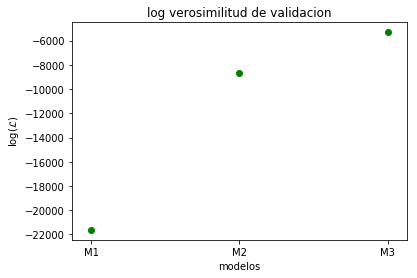

In [52]:
ll_val = np.array([l_v_1, l_v_2, l_v_3])
error_val = np.array([e_v_1, e_v_2, e_v_3])
mods = ['M1', 'M2', 'M3']
x = range(1, 4)
plt.xticks(x, mods)
plt.scatter(x, ll_val, color='green')
plt.title('log verosimilitud de validacion')
plt.xlabel('modelos')
plt.ylabel(r'$\log(\mathcal{L})$')
plt.savefig('final_loglike', dpi=123)

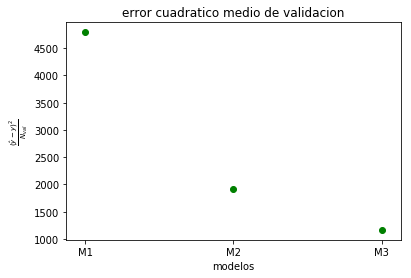

In [51]:
plt.xticks(x, mods)
plt.scatter(x, error_val, color='green')
plt.title('error cuadratico medio de validacion')
plt.xlabel('modelos')
plt.ylabel(r'$\frac{(\hat{y}-y)^{2}}{N_{val}}$')
plt.savefig('final_error', dpi=123)

Al agregar la segunda componente sinusoidal, se baja tanto el error de validacion y de entrenamiento.

In [53]:
!git status

On branch master
Your branch is up-to-date with 'origin/master'.
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   .ipynb_checkpoints/Tarea_2-checkpoint.ipynb
	modified:   Tarea_2.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	datos.png
	error_pol.png
	final_error.png
	final_loglike.png
	modelo_1.png
	modelo_2.png
	modelo_pol.png

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
git a